In [1]:
import torch
from torch import nn
import torch.utils.data as Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def Create_Matrix(data, timesteps):
    x, y = [], []
    for i in range(timesteps, data.shape[0]):
        x.append(data[i - timesteps:i])
        y.append(data[i])
    return np.array(x), np.array(y)

In [3]:
def Split(x, y, seed=0):
    a = int(0.8 * x.shape[0])
    b = int(0.9 * x.shape[0])
    index = np.arange(a)
    np.random.seed(seed)
    np.random.shuffle(index)
    return x[:a][index], y[:a][index], x[a:b], y[a:b], x[b:], y[b:]

In [4]:
class StandardScaler:
    def __init__(self, data):
        self.mean = np.mean(data)
        self.std = np.std(data)

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return data * self.std + self.mean

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=False):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional == True:
            num_dir = 2
        else:
            num_dir = 1
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.sequential = nn.Sequential(
            nn.Linear(num_dir*hidden_size, hidden_size//2), 
            nn.BatchNorm1d(hidden_size//2), 
            nn.LeakyReLU(0.2), 
            nn.Linear(hidden_size//2, output_size), 
        )
        
    def forward(self, x):
        x, _ = self.lstm(x, None)
        x = x[:, -1, :]
        return self.sequential(x)

In [6]:
timesteps = 90
data = pd.read_csv('bdi.csv', parse_dates=['date'], index_col=['date']).fillna(method='ffill').values

x, y = Create_Matrix(data, timesteps)
x_train, y_train, x_val, y_val, x_test, y_test = Split(x, y)

scaler = StandardScaler(y_train)
y_train = scaler.transform(y_train)
x_train = scaler.transform(x_train)
y_val = scaler.transform(y_val)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [7]:
x_train = torch.FloatTensor(x_train).cuda()
y_train = torch.FloatTensor(y_train).cuda()
x_val = torch.FloatTensor(x_val).cuda()
y_val = torch.FloatTensor(y_val).cuda()
x_test = torch.FloatTensor(x_test).cuda()

In [8]:
dataset = Data.TensorDataset(x_train, y_train)
dataloader = Data.DataLoader(dataset=dataset, 
                         batch_size=512, 
                         shuffle=True
                        )

In [9]:
model = RNN(input_size=1, hidden_size=64, num_layers=2, 
                     output_size=1, bidirectional=True).cuda()
adam = torch.optim.Adam(model.parameters(), lr=0.01)
sgd = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [10]:
epochs = 50
history = dict()
history['loss'] = []
history['val_loss'] = []
for epoch in range(epochs):
    for x_batch, y_batch in dataloader:
        model.train(True)
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        adam.zero_grad()
        loss.backward()
        adam.step()
        model.train(False)
        y_pred = model(x_val)
        val_loss = criterion(y_pred, y_val)
    loss = loss.item()
    val_loss = val_loss.item()
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    print(f'Epoch {1+epoch:03d}/{epochs} loss: {loss} - val_loss: {val_loss}')

Epoch 001/50 loss: 0.005117731634527445 - val_loss: 0.08622332662343979
Epoch 002/50 loss: 0.012095934711396694 - val_loss: 0.06173127517104149
Epoch 003/50 loss: 0.002903959946706891 - val_loss: 0.0468876026570797
Epoch 004/50 loss: 0.00948358979076147 - val_loss: 0.011303541250526905
Epoch 005/50 loss: 0.015812069177627563 - val_loss: 0.0038109803572297096
Epoch 006/50 loss: 0.005425732582807541 - val_loss: 0.005167955532670021
Epoch 007/50 loss: 0.011741243302822113 - val_loss: 0.024465082213282585
Epoch 008/50 loss: 0.00568249961361289 - val_loss: 0.0054268972016870975
Epoch 009/50 loss: 0.0018899283604696393 - val_loss: 0.01872304268181324
Epoch 010/50 loss: 0.008737548254430294 - val_loss: 0.0029874152969568968
Epoch 011/50 loss: 0.0019332760712131858 - val_loss: 0.0002329551352886483
Epoch 012/50 loss: 0.0021350039169192314 - val_loss: 0.000963973521720618
Epoch 013/50 loss: 0.008551254868507385 - val_loss: 0.005357845686376095
Epoch 014/50 loss: 0.005060362629592419 - val_loss:

In [11]:
model.train(False)
pred = model(x_test)
pred = pred.cpu().detach().numpy()
pred = scaler.inverse_transform(pred)

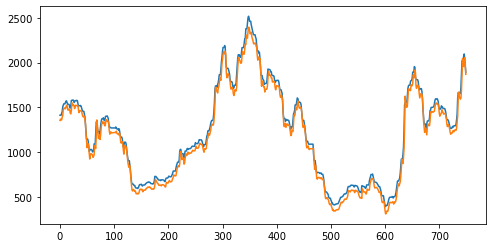

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(y_test)
plt.plot(pred)
plt.show()

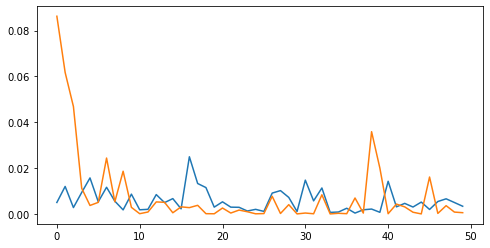

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.show()